In [2]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.spatial.distance import cdist
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Urbansurge imports.
from urbansurge import swmm_model
from urbansurge.fault_diagnosis import cnn_fault_classifier, ann_fault_classifier

%load_ext autoreload
%autoreload 2

In [22]:
# Concatenate fault database csv files.
csv_dir = Path(r'C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output')

csv_fnames = [
    'diameter_impulse_fault_database.csv',
    'roughness_impulse_fault_database.csv',
    'silting_impulse_fault_database.csv'
]

# Load in fault data frames as a list.
df_list = [pd.read_csv(csv_dir / f) for f in csv_fnames]

# Concatenate into a single data frame.
fault_database_df = pd.concat(df_list)
fault_database_df.reset_index(drop=True, inplace=True)

# Load in fault-free system data frame.
healthy_fname = 'healthy_impulse_database.csv'
healthy_database_df = pd.read_csv(csv_dir / healthy_fname)

In [23]:
# Number of unique component, fault value, and fault type combinations.
grouped = fault_database_df.groupby(['fault_component', 'fault_value', 'fault_type'])
ngroups = grouped.ngroups
print(grouped.size())

fault_component  fault_value  fault_type
20               0.10         silting       360
                 0.14         silting       360
                 0.18         silting       360
                 0.22         silting       360
                 0.26         silting       360
                                           ... 
80               0.50         diameter      360
                 0.60         diameter      360
                 0.70         diameter      360
                 0.80         diameter      360
                 0.90         diameter      360
Length: 166, dtype: int64


## Compute depth and velocity residuals.

In [24]:
# Depth and velocity columns.
dep_vel_cols = [s for s in healthy_database_df if any(sub in s for sub in ['Depth_link', 'Velocity'])]

# Select sensors.
sensor_links = [20] #[39, 40, 41, 42, 43, 44, 45, 23, 21, 20]
dep_cols = [f'Depth_link_{s}' for s in sensor_links]
vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
dep_vel_cols = dep_cols + vel_cols
extra_fault_cols = [col for col in fault_database_df.columns if col not in dep_vel_cols]

# Add noise to depth and velocity sensors.
depth_var = 0.0
velocity_var = 0.0
fault_database_df.loc[:, dep_cols] += np.random.normal(0, depth_var, size=fault_database_df.loc[:, dep_cols].shape)
fault_database_df.loc[:, vel_cols] += np.random.normal(0, velocity_var, size=fault_database_df.loc[:, vel_cols].shape)

# Depth and velocity data from fault database.
fault_sensor_ar = fault_database_df[dep_vel_cols].to_numpy()

# # Add Gaussian noise to fault sensor array.
# fault_sensor_ar = fault_sensor_ar + np.random.normal(0, 0.5, size=fault_sensor_ar.shape)

# Depth and velocity data from healthy database.
healthy_sensor_ar = healthy_database_df[dep_vel_cols].to_numpy()

# Number of times to repeat the healthy sensor data.
repeats = ngroups
healthy_repeats = np.repeat(healthy_sensor_ar, repeats, axis=0)

# Create residual data.
residual_ar = healthy_repeats - fault_sensor_ar

# Residual data frame with fault data added back in. 
residual_df = pd.DataFrame(residual_ar, columns=dep_vel_cols)
residual_df = pd.merge(residual_df, fault_database_df[extra_fault_cols], left_index=True, right_index=True)

(59760, 368)
fault_component         20
fault_value           0.38
fault_type         silting
Name: 54720, dtype: object
Sensor 20


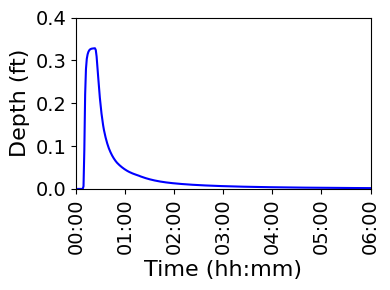

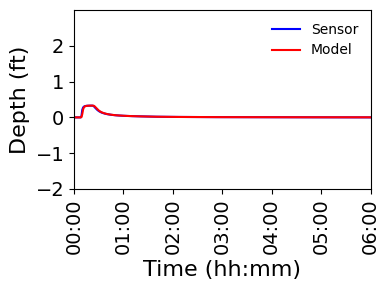

In [25]:
gi = 152
si = 0
print(fault_database_df.shape)
print(fault_database_df.loc[360*gi, ['fault_component', 'fault_value', 'fault_type']])
print('Sensor', sensor_links[si])


times = list(pd.to_datetime(healthy_database_df['datetime']))
times.insert(0, times[0] - timedelta(minutes=1))
healthy_sensor = list(healthy_database_df[f'Depth_link_{sensor_links[si]}'])
healthy_sensor.insert(0, 0)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(times, healthy_sensor, 'b')
ax.set_xlim(times[0], times[-1])
ax.set_ylim(0, 0.4)
ax.set_xlabel('Time (hh:mm)', fontsize=16)
ax.set_ylabel('Depth (ft)', fontsize=16)
ax.set_xticks(times[::60])
ax.tick_params(axis='both', labelsize=14)
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=90)
fig.tight_layout()
# fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Data\Documents\Impulse Fault Diagnosis\Figures\healthy_outflow.png", dpi=300)

gi = 0
fault_sensor = list(fault_database_df.loc[gi*360:gi*360+360, f'Depth_link_{sensor_links[si]}'])
# fault_sensor.insert(0, 0)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(times, fault_sensor, 'b', label='Sensor')
ax.plot(times, healthy_sensor, 'r', label='Model')
ax.set_xlabel('Time (hh:mm)', fontsize=16)
ax.set_ylabel('Depth (ft)', fontsize=16)
ax.set_xticks(times[::60])
ax.set_yticks(np.arange(-2, 3, 1))
ax.set_xlim(times[0], times[-1])
ax.set_ylim(-2, 3)
ax.tick_params(axis='both', labelsize=14)
ax.legend(frameon=False)
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=90)
fig.tight_layout()
# fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Data\Documents\Impulse Fault Diagnosis\Figures\noisy_outflow.png", dpi=300)


### Normalize depth residuals by maximum depth and velocity by link.

In [26]:
# Path to configuration file.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

# Link IDs.
link_ids = np.unique([int(re.search(r'[^_]+$', s).group(0)) for s in dep_vel_cols])

# Loop through link IDs and normalize depth and velocity residuals.
for link_id in link_ids:
    # Get pipe diameter.
    max_depth = swmm.get_link_geometry(link_id)[0]
    
    # Maximum velocity occurs at 78% of diameter.
    d_vmax = 0.78 * max_depth
    
    # Link roughness.
    n = swmm.get_link_roughness(link_id)
    
    # Link slope.
    S = swmm.get_link_slope(link_id)
    S = np.abs(S)
    
    # Link hydraulic radius at maximum velocity depth.
    Rh = swmm.get_link_circular_Rh(d_vmax, max_depth)
    
    # Compute maximum velocity.
    max_velocity = (1.49 / n) * Rh**(2/3) * S**(1/2)
    print(np.max(np.abs(fault_database_df[f'Velocity_link_{link_id}'])))
    print(max_velocity, '\n')
    
    # Normalize depth.
    residual_df[f'Depth_link_{link_id}'] = residual_df[f'Depth_link_{link_id}'] / max_depth
    
    # Normalize velocity.
    residual_df[f'Velocity_link_{link_id}'] = residual_df[f'Velocity_link_{link_id}'] / max_velocity
    

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00
7.055936813354492
12.409444464312068 



## Train classifier

In [27]:
# Features.
X = residual_df[dep_vel_cols].to_numpy()

# Labels.
# y = residual_df.loc[:, ['fault_component', 'fault_value', 'fault_type', 'storm']].to_numpy()
y = residual_df.loc[:, ['fault_component', 'fault_value', 'fault_type']].to_numpy()


# Split the training data on the storm ID.
y_df = pd.DataFrame(y)

# Add an index to maintain the original order
y_df['index'] = y_df.index

# Group by the labels
grouped = y_df.groupby(list(y_df.columns[:-1]))

# Extract the indices for each group
group_indices = [group.index.tolist() for _, group in grouped]

# Check sizes of groups.
group_sizes = set([len(g) for g in group_indices])
print('Group Sizes', set([len(g) for g in group_indices]))
max_group_size = max(group_sizes)
min_group_size = min(group_sizes)

# Separate data from X into images.
Ximg = np.zeros((max_group_size, X.shape[1], len(group_indices)))
for i, idxs in enumerate(group_indices):
    # Extract images.
    img = X[group_indices[i],:]
    Ximg[:img.shape[0],:,i] = img
    
# Cut to minimum group size.
Ximg = Ximg[:min_group_size,:,:]

# # Remove sensors.
# Ximg = Ximg[:,1:10,:]
    
yimg = y[[g[0] for g in group_indices]]

Group Sizes {360}


### Plot a residual image

[20 6.0 'roughness']


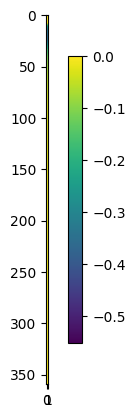

In [28]:
image_no = 30
fig, ax = plt.subplots()
im = ax.imshow(Ximg[:,:,image_no])
fig.colorbar(im, fraction=0.029, pad=0.04)

print(yimg[image_no,:])

[20 0.22 'silting']
[77 0.1 'diameter']


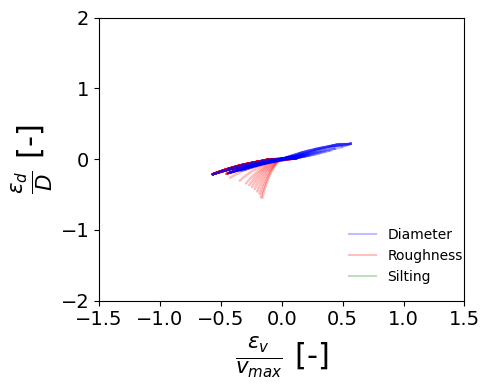

In [29]:
# 2D trajectory.
col1 = 'Velocity_link_20'
col2 = 'Depth_link_20'
col1i = dep_vel_cols.index(col1)
col2i = dep_vel_cols.index(col2)

imgno1 = 3
imgno2 = 130
print(yimg[imgno1,:])
print(yimg[imgno2,:])

fig, ax = plt.subplots(figsize=(5,4))
for i in range(Ximg.shape[2]):
    if yimg[i,2] == 'diameter':
        a1 = ax.plot(Ximg[:, col1i, i], Ximg[:, col2i, i], c='b', alpha=0.25)
    elif yimg[i,2] == 'roughness':
        a2 = ax.plot(Ximg[:, col1i, i], Ximg[:, col2i, i], c='r', alpha=0.25)
    elif yimg[i,2] == 'silting':
        a3 = ax.plot(Ximg[:, col1i, i], Ximg[:, col2i, i], c='g', alpha=0.25)

ax.set_xticks(np.arange(-1.5, 2, 0.5))
ax.set_yticks(np.arange(-2.0, 2.5, 1))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-2, 2])
ax.set_xlabel('$\\frac{\\epsilon_{v}}{v_{max}}$ [-]', fontsize=22)
ax.set_ylabel('$\\frac{\\epsilon_{d}}{D}$ [-]', fontsize=22)
ax.tick_params(axis='both', labelsize=14)
ax.legend([a1[0], a2[0], a3[0]], ['Diameter', 'Roughness', 'Silting'], fontsize=10, frameon=False, loc='upper right',
         bbox_to_anchor=(1.03, 0.3))
fig.tight_layout()
# fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Data\Documents\Impulse Fault Diagnosis\Figures\fault_features.png", dpi=300)

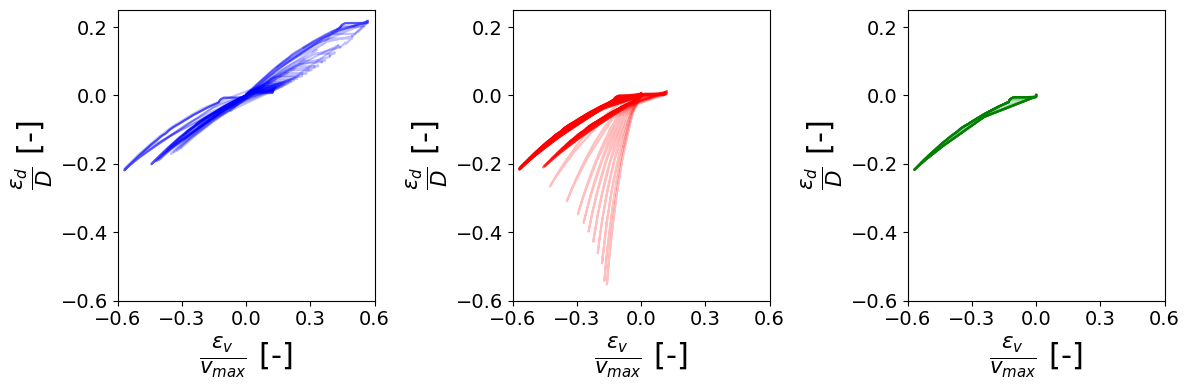

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
for i in range(Ximg.shape[2]):
    if yimg[i,2] == 'diameter':
        a1 = ax1.plot(Ximg[:, col1i, i], Ximg[:, col2i, i], c='b', alpha=0.25)
    elif yimg[i,2] == 'roughness':
        a2 = ax2.plot(Ximg[:, col1i, i], Ximg[:, col2i, i], c='r', alpha=0.25)
    elif yimg[i,2] == 'silting':
        a3 = ax3.plot(Ximg[:, col1i, i], Ximg[:, col2i, i], c='g', alpha=0.25)

for ax in [ax1, ax2, ax3]:
    ax.set_xticks(np.arange(-0.6, 0.9, 0.3))
    ax.set_yticks(np.arange(-0.6, 0.25, 0.2))
    ax.set_xlim([-0.6, 0.6])
    ax.set_ylim([-0.6, 0.25])
    ax.set_xlabel('$\\frac{\\epsilon_{v}}{v_{max}}$ [-]', fontsize=22)
    ax.set_ylabel('$\\frac{\\epsilon_{d}}{D}$ [-]', fontsize=22)
    ax.tick_params(axis='both', labelsize=14)
#     ax.legend([a1[0], a2[0], a3[0]], ['Diameter', 'Roughness', 'Silting'], fontsize=10, frameon=False, loc='upper right',
#              bbox_to_anchor=(1.03, 0.3))
fig.tight_layout()

## Fault classification.

### Nearest neighbor

(166, 720)
['silting', 'diameter', 'roughness', 'diameter', 'diameter', 'roughness', 'roughness', 'roughness', 'roughness', 'diameter', 'diameter', 'roughness', 'roughness', 'diameter', 'roughness', 'roughness', 'roughness', 'diameter', 'roughness', 'roughness', 'roughness', 'diameter', 'roughness', 'roughness', 'roughness', 'roughness', 'roughness', 'roughness', 'silting', 'silting', 'silting', 'silting', 'roughness', 'roughness', 'diameter', 'roughness', 'silting', 'roughness', 'roughness', 'silting', 'silting', 'diameter']
['roughness' 'roughness' 'roughness' 'diameter' 'roughness' 'silting'
 'roughness' 'roughness' 'diameter' 'diameter' 'roughness' 'roughness'
 'roughness' 'diameter' 'silting' 'diameter' 'silting' 'diameter'
 'roughness' 'diameter' 'diameter' 'diameter' 'roughness' 'roughness'
 'roughness' 'roughness' 'roughness' 'silting' 'roughness' 'silting'
 'roughness' 'roughness' 'silting' 'diameter' 'roughness' 'roughness'
 'roughness' 'silting' 'diameter' 'roughness' 'rough

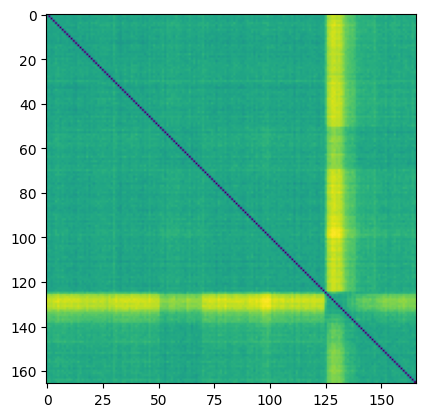

In [17]:
# Flatten Ximg into single row vectors.
Ximg_nn = Ximg.transpose(1, 0, 2).reshape(-1, Ximg.shape[2]).T
print(Ximg_nn.shape)

# Compute the Euclidean distance matrix
dist_matrix = cdist(Ximg_nn, Ximg_nn, metric='euclidean')

# Check if the distance to itself (diagonal elements) is the smallest
is_self_distance_smallest = (dist_matrix <= dist_matrix.diagonal()).diagonal()

fig, ax = plt.subplots()
ax.imshow(dist_matrix)

# Split into test and training.
Xnn_train, Xnn_test, ynn_train, ynn_test = train_test_split(Ximg_nn, yimg)

ynn_pred = []
for i in range(Xnn_test.shape[0]):
    distances = np.linalg.norm(Xnn_train - Xnn_test[i,:], axis=1)

    # Find the index of the row with the smallest distance
    min_distance_index = np.argmin(distances)
    ynn_pred.append(ynn_train[min_distance_index,2])
    
print(ynn_pred)
print(ynn_test[:,2])

_, ynn_pred_cat = np.unique(ynn_pred, return_inverse=True)
_, ynn_test_cat = np.unique(ynn_test[:,2], return_inverse=True)
print(ynn_pred_cat)
print(ynn_test_cat)
print(np.sum(ynn_pred_cat == ynn_test_cat) / len(ynn_pred_cat))
print(metrics.confusion_matrix(ynn_test_cat, ynn_pred_cat))

### NN Classifiers

In [18]:
# Convert fault type column to categorical values.
_, yimg_cat = np.unique(yimg[:,2], return_inverse=True)

# CNN classifier.
# =================================================================
# Convert to torch tensors
Ximg_t = torch.tensor(Ximg, dtype=torch.float32)
yimg_t = torch.tensor(yimg_cat, dtype=torch.long)

# If the images are grayscale, add a channel dimension
Ximg_t = Ximg_t.unsqueeze(0)  # Now shape (1, n, m, k)
Ximg_t = Ximg_t.permute(3, 0, 1, 2)  # Now shape (k, 1, n, m)

In [13]:
print(Ximg_t.shape)

torch.Size([166, 1, 360, 2])


In [22]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
# Define any additional transforms if needed
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # Example normalization for grayscale images
])

# Create the dataset and dataloader
dataset = ImageDataset(Ximg_t, yimg_t, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train, validation, test split.
generator1 = torch.Generator().manual_seed(40)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator1)

# Dataloaders.
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model, loss function, and optimizer
model = cnn_fault_classifier.SimpleCNN()
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    print(epoch)

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
            
print('Training finished.')

0
torch.Size([32, 64, 90, 5])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x28800 and 79360x128)

In [19]:
# ANN classifier.
# =================================================================
class ANNDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
            
        return data, label

# Create tensors to pass into ANN.
Ximg_ann = torch.tensor(Ximg, dtype=torch.float32)
Ximg_ann = Ximg_ann.flatten(end_dim=1)
print(Ximg_ann.shape)

# Convert fault type column to categorical values.
_, yimg_cat = np.unique(yimg[:,2], return_inverse=True)
yimg_ann = torch.tensor(yimg_cat, dtype=torch.long)

# Create the dataset and dataloader
dataset = ANNDataset(Ximg_t, yimg_t)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train, validation, test split.
generator1 = torch.Generator().manual_seed(40)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator1)

# Dataloaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model, loss function, and optimizer
model = ann_fault_classifier.SimpleANN()
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 200  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    print(epoch)

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
            
print('Training finished.')

torch.Size([720, 166])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Training finished.


## Test classifier

In [20]:
# Set the model to evaluation mode
model.eval()

# Storage for predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient calculations for efficiency
with torch.no_grad():
    for inputs, labels in test_loader:
        # If using a GPU, move data to GPU
        # inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute the model output
        outputs = model(inputs)

        # For classification, get the class index with the highest score
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to arrays if necessary
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

In [21]:
# Accuracy metrics.
N = len(all_labels)
match = all_predictions == all_labels
print(all_predictions)
print(all_labels)
TP = np.sum(match)
TPR = TP / N
print('True Positive Rate: {:.2f}'.format(TPR))

# Confusion matrix.
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)
print(confusion_matrix)

# Test dataset indices.
test_idxs = test_dataset.indices

# # Storm intensities for test data.
# storm_values = yimg[test_idxs,3]
# storm_correct_rate = {}
# for storm in np.unique(storm_values):
#     storm_idxs = storm_values == storm
#     storm_correct_rate[storm] = np.sum(match[storm_idxs]) / np.sum(storm_idxs)
    
# print('\n', 'STORM', storm_correct_rate)

# Fault severity.
severity_values = yimg[test_idxs,1]
severity_correct_rate = {}
for severity in np.unique(severity_values):
    severity_idxs = severity_values == severity
    severity_correct_rate[severity] = np.sum(match[severity_idxs]) / np.sum(severity_idxs)
    
print('\n', 'SEVERITY', severity_correct_rate)

# Fault component.
component_values = yimg[test_idxs,0]
component_correct_rate = {}
for component in np.unique(component_values):
    component_idxs = component_values == component
    component_correct_rate[component] = np.sum(match[component_idxs]) / np.sum(component_idxs)
    
print('\n', 'COMPONENT', component_correct_rate)

[0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1]
[0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 2 1 0 1 1 1 1]
True Positive Rate: 0.94
[[10  0  0]
 [ 1 21  0]
 [ 0  1  0]]

 SEVERITY {0.1: 1.0, 0.2: 1.0, 0.3399999999999999: 1.0, 0.4: 1.0, 0.5: 1.0, 0.6: 1.0, 0.7000000000000001: 1.0, 0.9: 1.0, 1.5: 0.6666666666666666, 2.0: 1.0, 2.5: 1.0, 3.0: 1.0, 3.5: 1.0, 4.0: 0.5, 4.5: 1.0, 5.0: 1.0, 5.5: 1.0, 6.0: 1.0}

 COMPONENT {20: 1.0, 23: 1.0, 40: 1.0, 41: 1.0, 42: 0.5, 43: 1.0, 44: 0.5, 45: 1.0, 76: 1.0, 78: 1.0, 79: 1.0, 80: 1.0}


### UNUSED CODE

In [232]:
def create_storm_ids(length, repeat):
    result = []
    num = 1
    while len(result) < length:
        # Determine the number of repetitions that can be added without exceeding the length
        repetitions = min(repeat, length - len(result))
        result.extend([num] * repetitions)
        num += 1
    return result

In [233]:
# Assign a storm ID to all identical storms in fault data.
storm_length = 50

# Get length of one record.
grouped = fault_database_df.groupby(['fault_component', 'fault_value'])

storm_id_col = []
for name, group in grouped:
    # Number of rows in group.
    nrow = group.shape[0]
    
    # Storm IDs. 
    storm_ids = create_storm_ids(nrow, storm_length)
    storm_id_col.extend(storm_ids)

# Add storm ID column to data frame.
fault_database_df['storm'] = storm_id_col

In [5]:
# Assign a storm ID to all identical storms in healthy data.
storm_ids = create_storm_ids(healthy_database_df.shape[0], storm_length)

# Add column to healthy database df.
healthy_database_df['storm'] = storm_ids